## Прогнозирование спроса на игры на основе данных "Стримчик"


Данный блокнот анализирует и прогнозирует игровую индустрию. За основу берутся исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Целью является выявление закономерностей успеха игр и составление прогноза для рекламной кампании на 2017 год. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

### Знакомство с данными


In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
print(df.head())
df.info()

                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 

Запишем данные в переменную df и изучим их начальное состояние. 

1. Закрадываются сомнения по поводу названий игр в столбце Name - возможно будет очень много неявных дубликатов.
2. Аналогично с названиями платформ.
3. Столбец 'Year_of_Release' содержит в себе года выпуска игр, которые нужно перевести в тип int.
4. Оценки критиков и геймеров не должны быть выше 100 и 10 соответственно.
5. Пропуски в оценках критиков и геймеров являются критичными. Их нельзя заполнить, так как это искозит общую картину. Придется избавляться от таких игр.

Будем копать данные в порядке, описанном выше.

### Предобработка данных


In [4]:
df['Name'] = df['Name'].str.lower()
df['Platform'] = df['Platform'].str.lower()
df['Year_of_Release'].isna().sum()
df = df.dropna(subset = ['Year_of_Release'])
df['Year_of_Release'] = df['Year_of_Release'].astype(int)
df = df.dropna(subset = ['Name'])
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16444 non-null  object 
 1   Platform         16444 non-null  object 
 2   Year_of_Release  16444 non-null  int64  
 3   Genre            16444 non-null  object 
 4   NA_sales         16444 non-null  float64
 5   EU_sales         16444 non-null  float64
 6   JP_sales         16444 non-null  float64
 7   Other_sales      16444 non-null  float64
 8   Critic_Score     7983 non-null   float64
 9   User_Score       9839 non-null   object 
 10  Rating           9768 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB
None


Названия игр и платформ приведены к нижнему регистру. Обработаем столбец с данными по годам выхода: избавимся от строк, где год отсутствует, а так же приведем год к типу численных данных. Так же удалим 2 пропуска в столбце с названием игры. Решать судьбу пропусков в оценках критиков и пользователей, а так же рэйтинга, будем по мере необходимости.

Огромное количество пропусков в рейтингах, возможно, связаны с низкой популярностью игр, где присутствуют пропуски. Допустим, какие-то малоизвестные инди-проекты, где количество пользователей меньше определенной квоты, при которой формируется оценка.

In [5]:
def nan_check(df, column):
    title_dict = {'Name','Platform','Year_of_Release','Genre', 'NA_sales', 'EU_sales', 'JP_sales',
                  'Other_sales', 'Critic_Score', 'User_Score', 'Rating'}
    check = df[column].isna().sum()
    return check
nan_check(df, 'Rating')

6676

In [6]:
df.rename(columns = {'Name':'name', 'Platform':'platform',
                     'Year_of_Release':'year','Genre':'genre',
                     'NA_sales':'na_sales','EU_sales':'eu_sales',
                     'JP_sales':'jp_sales','Other_sales':'other_sales',
                     'Critic_Score':'critic_score','User_Score':'user_score',
                     'Rating':'rating'}, inplace = True )


In [7]:
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df[df['user_score'] == 'tbd'].sort_values('sum_sales', ascending = False)

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
119,zumba fitness,wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E,6.70
301,namco museum: 50th anniversary,ps2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+,3.97
520,zumba fitness 2,wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T,2.81
645,udraw studio,wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E,2.42
718,just dance kids,wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E,2.24
...,...,...,...,...,...,...,...,...,...,...,...,...
15983,mission: impossible - operation surma,gc,2004,Platform,0.01,0.00,0.0,0.00,64.0,tbd,T,0.01
15979,monster trux offroad,wii,2007,Racing,0.01,0.00,0.0,0.00,NaN,tbd,E,0.01
15975,paranormal pursuit: the gifted one,pc,2015,Action,0.00,0.01,0.0,0.00,NaN,tbd,NaN,0.01
15963,dead to rights,gba,2004,Shooter,0.01,0.00,0.0,0.00,40.0,tbd,T,0.01


Я предположу, что tbd в столбце user_score обозначает отсутствие данных об оценке пользователей. Предположение обосновано крайне низкими продажами, сумму которых мы посчитали в отдельном df. Максимальный объем продаж игры без оценки пользователя - 6.7 млн копий. В таком случае, правильным решением будет заполнить пропуски в оценках и рейтинге значением tbd, который будет пинговать об отсутствии значений.

In [8]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['critic_score'] = df['critic_score'].replace('tbd', np.nan)
df['rating'] = df['rating'].replace('tbd', np.nan)
df.info()
df['rating'].unique()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16444 non-null  object 
 1   platform      16444 non-null  object 
 2   year          16444 non-null  int64  
 3   genre         16444 non-null  object 
 4   na_sales      16444 non-null  float64
 5   eu_sales      16444 non-null  float64
 6   jp_sales      16444 non-null  float64
 7   other_sales   16444 non-null  float64
 8   critic_score  7983 non-null   float64
 9   user_score    7463 non-null   object 
 10  rating        9768 non-null   object 
 11  sum_sales     16444 non-null  float64
dtypes: float64(6), int64(1), object(5)
memory usage: 1.6+ MB


array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Данные все оставил. В частях работы, где необходимо обращаться к данным по оценкам и рейтингу, добавлены фильтры. 

In [9]:
df.duplicated().sum()

0

In [10]:
duplicateRows = df[df.duplicated(['name', 'platform', 'year'])]
duplicateRows
df[df['name'] == 'madden nfl 13']

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
507,madden nfl 13,x360,2012,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E,2.85
604,madden nfl 13,ps3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E,2.56
3986,madden nfl 13,wii,2012,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E,0.50
5887,madden nfl 13,psv,2012,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E,0.30
7066,madden nfl 13,wiiu,2012,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E,0.23
16230,madden nfl 13,ps3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E,0.01


Явные дубликаты отсутствуют.

Ты прав. Стоило проверять неявные дубликаты. Как следствие, был найден неявный дубликат: игра 'madden nfl 13' на платформе ps3. Данный дубликат является, скорее всего, ошибкой при вводе данных, так как основных данных по продажам в дубликате нет. Но Присутствуют оценки. Так как позже мы будем изучать оценки пользователей, данный дубликат может искажать результаты. Избавимся от дубликата.

In [11]:
df = df.drop(labels = [16230],axis = 0)
df[df['name'] == 'madden nfl 13']

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
507,madden nfl 13,x360,2012,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E,2.85
604,madden nfl 13,ps3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E,2.56
3986,madden nfl 13,wii,2012,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E,0.50
5887,madden nfl 13,psv,2012,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E,0.30
7066,madden nfl 13,wiiu,2012,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E,0.23


По итогам предобработки данных было сделано:

1. Все данные были приведены к нижнему регистру.
2. Удалены строки, где отсутствуют данные по году выпуска, оценкам критиков, пользователей и рейтингу, а так же названия игр.
3. Было расшифровано значение tbd - отсутствие данных об оценках пользователей. Такие данные были удалены.
4. Были выявлены неявные дубликаты - игра 'madden nfl 13' на платформе ps3. Данный дубликат был удален из данных.
5. Явных дубликатов не было найдено.

### Исследовательский анализ данных


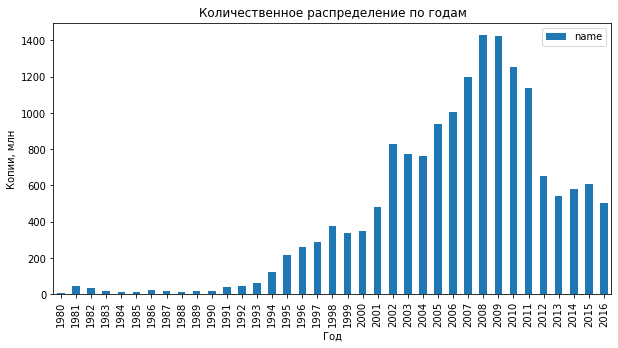

In [12]:
pivot_game = df\
.pivot_table(index=['year'], values=['name'], aggfunc='count')\
.sort_values(by='year', ascending=True)
pivot_game.plot(kind = 'bar', y = 'name', figsize = (10,5)) .set(title='Количественное распределение по годам');
plt.xlabel('Год');
plt.ylabel('Копии, млн');

Пик игровой индустрии приходился на конец первого десятилетия. График распределения подходит под формат нормального распределения с выбросами в начале 00-ых.Естественно, что рынок видеоигр очень гибок и изменчив: то, что было популярно в 90-ых, 00-ых, 10-ых очень сильно отличается. В связи с чем, я бы предположил, что нас должны интересовать данные за последние 10 лет. 

Для более наглядного анализа исключим платформы, на которые было продано менее 50 млн копий. Также избавимся от платформ, которые были уже давно забыты. Я бы проверил, когда на рынок вышли актуальные на прогнозируемый год консоли. 

platform
ps2     1233.56
x360     961.24
ps3      931.33
wii      891.18
ds       802.78
ps       727.58
ps4      314.14
gba      312.88
psp      289.53
3ds      257.81
pc       255.76
gb       254.43
xb       251.57
nes      251.05
n64      218.01
snes     200.04
gc       196.73
xone     159.32
2600      86.48
wiiu      82.19
psv       53.81
sat       33.59
gen       28.35
dc        15.95
scd        1.86
ng         1.44
ws         1.42
tg16       0.16
3do        0.10
gg         0.04
pcfx       0.03
Name: sum_sales, dtype: float64
platform    3ds     ds    gba     gc     pc    ps2    ps3    ps4    psp  \
year                                                                      
1985        NaN    1.0    NaN    NaN    1.0    NaN    NaN    NaN    NaN   
1988        NaN    NaN    NaN    NaN    1.0    NaN    NaN    NaN    NaN   
1992        NaN    NaN    NaN    NaN    5.0    NaN    NaN    NaN    NaN   
1994        NaN    NaN    NaN    NaN    6.0    NaN    NaN    NaN    NaN   
1995        N

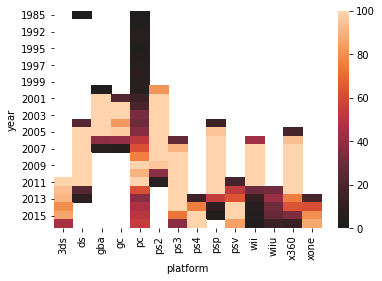

In [13]:
top_category = df.groupby('platform')['sum_sales'].sum().sort_values(ascending = False)
print(top_category)
top_category = df.query(' platform not in ("sat", "gen", "dc", "scd", "ng", "ws", "tg16", "3do", "gg", "pcfx", "2600", "gb", "n64", "nes", "ps", "snes", "xb" )')
pivot_platform = pd.pivot_table(index = 'year', columns = 'platform',
                                values = 'name', data = top_category, 
                                aggfunc = 'count')
print(pivot_platform)
sns.heatmap(pivot_platform, vmin= 0, vmax= 100, center= 0);

In [14]:
top_category[top_category['platform'] == 'ds'].sort_values(by = 'year')

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
15957,strongest tokyo university shogi ds,ds,1985,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02
13463,cocoto kart racer,ds,2004,Racing,0.04,0.00,0.00,0.00,NaN,NaN,E,0.04
11517,kenshuui tendo dokuta,ds,2004,Simulation,0.00,0.00,0.08,0.00,NaN,NaN,NaN,0.08
4421,the urbz: sims in the city (all regions sales),ds,2004,Simulation,0.40,0.01,0.02,0.00,NaN,NaN,NaN,0.43
7902,daigasso! band brothers,ds,2004,Misc,0.00,0.00,0.19,0.00,NaN,NaN,NaN,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...
7460,disney's planes,ds,2013,Simulation,0.11,0.08,0.00,0.02,NaN,NaN,E,0.21
14716,lego legends of chima: laval's journey,ds,2013,Adventure,0.00,0.03,0.00,0.00,NaN,NaN,E10+,0.03
7993,the smurfs 2,ds,2013,Platform,0.00,0.17,0.00,0.01,NaN,NaN,E,0.18
3862,frozen: olaf's quest,ds,2013,Platform,0.21,0.26,0.00,0.04,NaN,NaN,NaN,0.51


Погуглив данную игру, было выяснено, что это ошибка при вводе даты, так как релиз данной игры для платформы состоялся в 2007 году. Внесем правки.

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


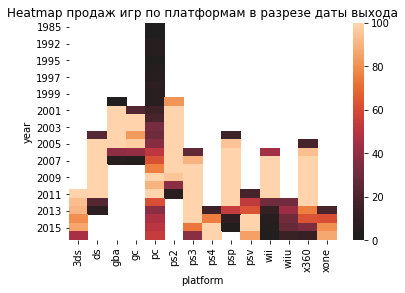

In [15]:
top_category = df.groupby('platform')['sum_sales'].sum().sort_values(ascending = False)
top_category = df.query(' platform not in ("sat", "gen", "dc", "scd", "ng", "ws", "tg16", "3do", "gg", "pcfx", "2600", "gb", "n64", "nes", "ps", "snes", "xb" )')
top_category.loc[15957, 'year'] = 2005
pivot_platform = pd.pivot_table(index = 'year', columns = 'platform',
                                values = 'name', data = top_category, 
                                aggfunc = 'count')
plt.title('Heatmap продаж игр по платформам в разрезе даты выхода')
plt.xlabel('year')
plt.ylabel('platform')
sns.heatmap(pivot_platform, vmin= 0, vmax= 100, center= 0);

После повторного вывода тепловой диаграммы, можем видеть приятную картину: все платформы != pc - имеют игры с релизом от 00-ых.

In [16]:
top7 = top_category.pivot_table(index='platform', values='sum_sales', aggfunc='sum').nlargest(7, 'sum_sales')
top7 = list(top7.index)
top7

['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps4', 'gba']

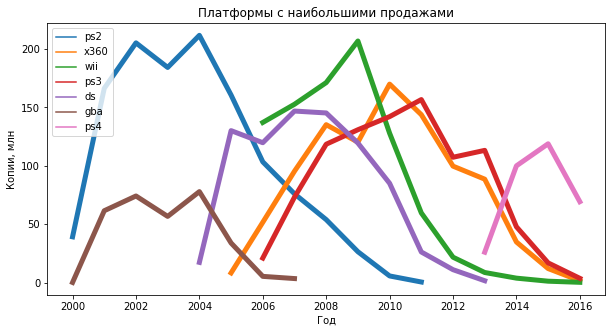

In [17]:
top_sales = pd.pivot_table(index='year', columns='platform', values='sum_sales',data = top_category , aggfunc='sum')
top7 = top_sales.loc[:, ['ps2', 'x360', 'wii', 'ps3', 'ds', 'gba', 'ps4']]
plt.figure(figsize=(10,5))
sns.lineplot(data = top7, linewidth = 5, dashes=False)
plt.title('Платформы с наибольшими продажами')
plt.xlabel('Год')
plt.ylabel('Копии, млн')
plt.legend(loc='upper left', fontsize=10)
plt.show()

В каждый период времени были свои популярные платформы. Нопопулярность постоянно переходила от одной к другой платформе. Я бы сказал, что "жизненный цикл" платформы, в среднем, 5 лет. Эта цифра зависит от силы бренда. Так же, отныне, будем считать период 2012-2016 - актуальный период исследований для анализа и прогнозирования.



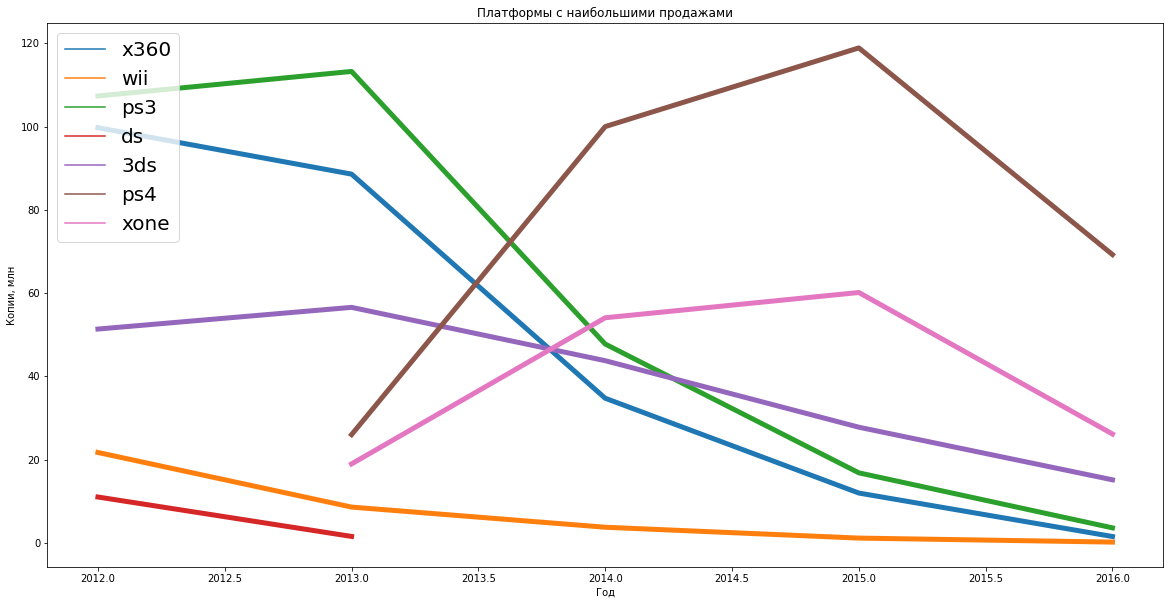

In [18]:
df2 = df[df['year'] > 2011].reset_index(drop = True)
top_sales = pd.pivot_table(index='year', columns='platform', values='sum_sales',data = df2 , aggfunc='sum')
top7 = top_sales.loc[:, [ 'x360', 'wii', 'ps3', 'ds', '3ds', 'ps4', 'xone']]
plt.figure(figsize=(20,10))
sns.lineplot(data = top7, linewidth = 5, dashes=False)
plt.title('Платформы с наибольшими продажами')
plt.xlabel('Год')
plt.ylabel('Копии, млн')
plt.legend(loc='upper left', fontsize=20)
plt.show()

Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Сразу бы высказал мысль, что прибыльность платформ в штуках измерять крайне странно. Но предположим, что стоимость игр на всех платформах +- равная. Заметим, что к 2016 году платформы начинают терять свою актуальность. Но на рынке появляются платформы нового поколения (ps4, xone). На данном этапе проблематично определить наиболее прибыльные платформы, так как выбранный период является закатом одной эры платформ и началом другой эры. Таким образом, для прогнозируемого 2017 года актуальными платформами для анализа являются xone и ps4. Именно эти платформы лидируют по продажам ближе к актуальному году и прогнозируемому году.

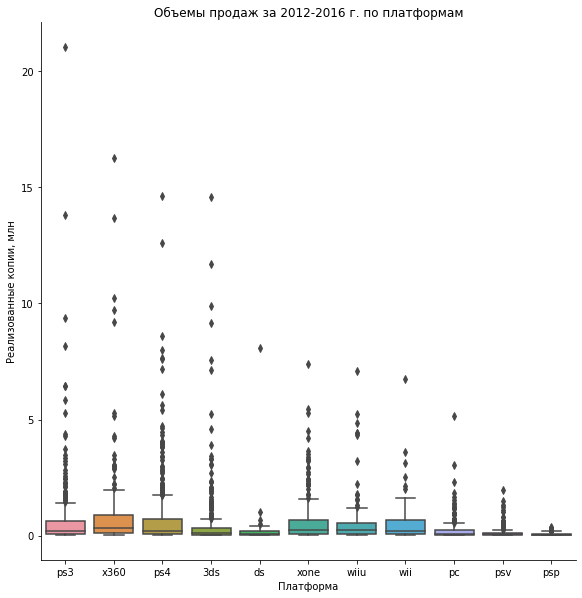

In [19]:
sns.catplot(x="platform", 
            y='sum_sales', 
            kind="box", 
            data=df2, 
            height=8)
plt.title('Объемы продаж за 2012-2016 г. по платформам')
plt.xlabel('Платформа')
plt.ylabel('Реализованные копии, млн');

(0.0, 4.0)

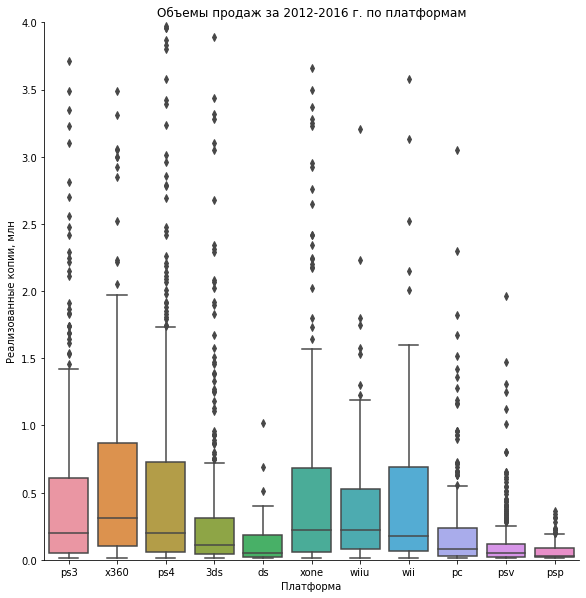

In [20]:
sns.catplot(x="platform", 
            y='sum_sales', 
            kind="box", 
            data=df2, 
            height=8)
plt.title('Объемы продаж за 2012-2016 г. по платформам')
plt.xlabel('Платформа')
plt.ylabel('Реализованные копии, млн')
plt.ylim(0, 4)

Большинство продаж по платформам не достигают миллиона копий, но существуют проекты, продажи которых достигают миллионов проданных копий. 

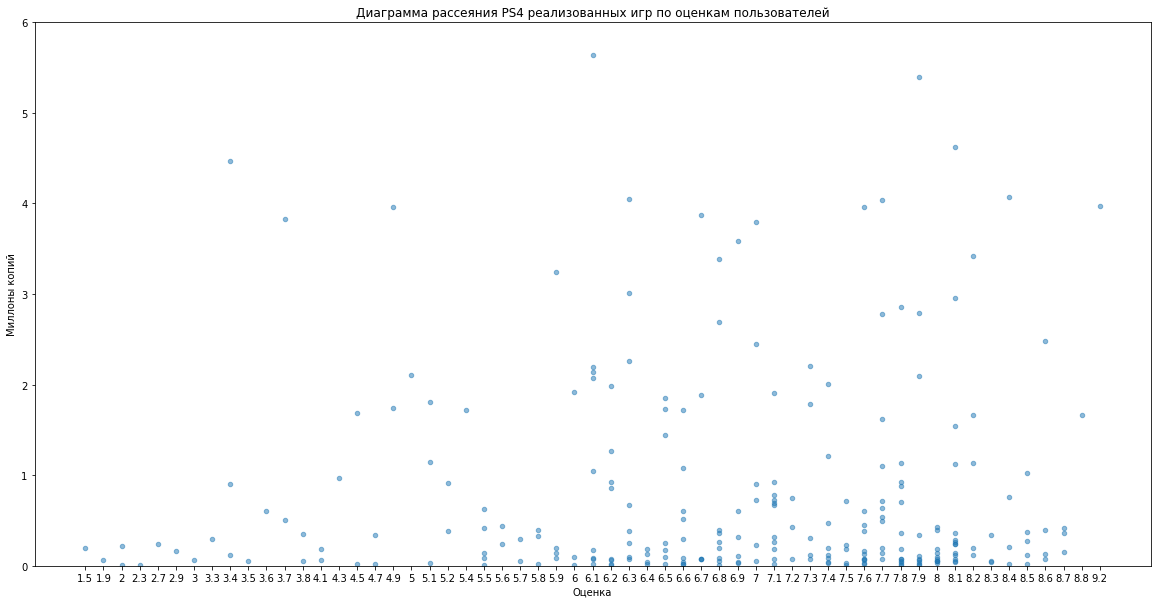

-0.03195711020455646

In [21]:
ps_4 = df2.dropna(subset = ['user_score'])
ps_4 = ps_4.query('platform == "ps4" & user_score != "nan"').sort_values(by = 'user_score')
ps_4.plot (kind = 'scatter', x = 'user_score', y = 'sum_sales', figsize = (20, 10), alpha = 0.5);
plt.ylim(0, 6)
plt.title('Диаграмма рассеяния PS4 реализованных игр по оценкам пользователей')
plt.xlabel('Оценка')
plt.ylabel('Миллоны копий')
plt.show()
ps_4['user_score'] = ps_4['user_score'].astype(float)
ps_4['user_score'].corr(ps_4['sum_sales'])

Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Удивительно, но связи между оценками пользователей и количеством проданных копий на платформе ps_4 нет. Игры с низким рейтингом продаются миллионами, в то время как игры с высоким рейтингом все меньше продаются.

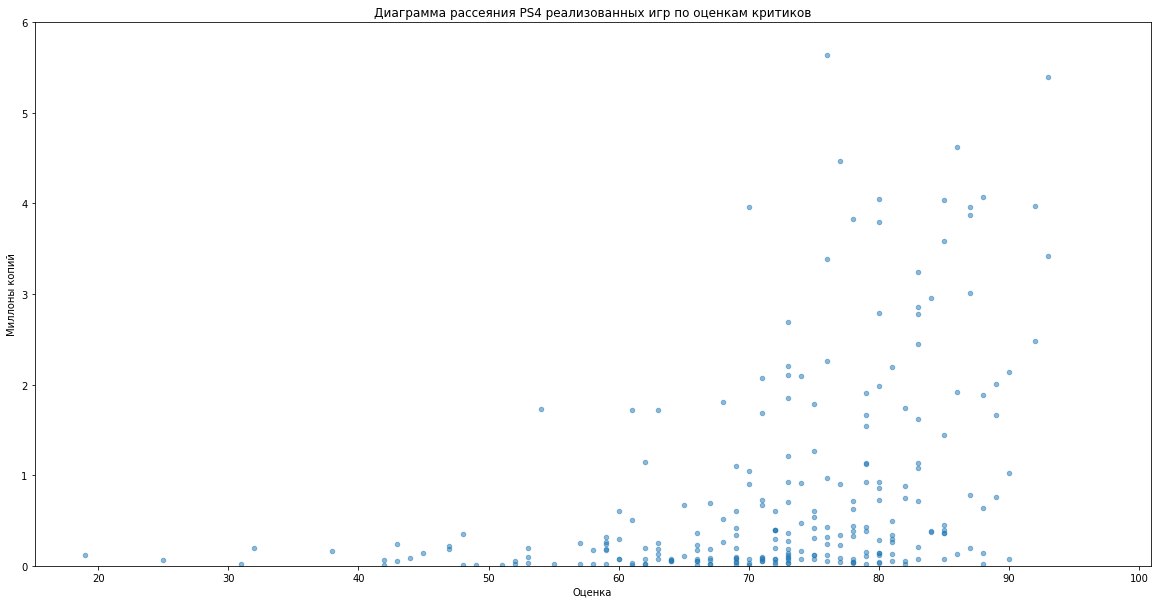

0.40656790206178167

In [22]:
ps_4 = df2.query('platform == "ps4"').sort_values(by = 'critic_score')
ps_4 = ps_4[ps_4['critic_score'] != 'tbd']
ps_4.plot.scatter (x = 'critic_score', y = 'sum_sales', figsize = (20, 10), alpha = 0.5);
plt.ylim(0, 6)
plt.title('Диаграмма рассеяния PS4 реализованных игр по оценкам критиков')
plt.xlabel('Оценка')
plt.ylabel('Миллоны копий')
plt.show()
ps_4['critic_score'] = ps_4['critic_score'].astype(float)
ps_4['critic_score'].corr(ps_4['sum_sales'])

Оценка критиков коррелирует с объемами продаж. Нельзя утверждать, что связь значимая (коэффициент корреляции - 0.4), но, визуально, на диаграмме рассеяния явно видно, что объемы продаж имеют тенденцию к росту на оценке 60-90. 

Предположу, что оценки пользователей формируются уже после покупки и прохождения игры. Это логично, ведь рядовой пользователь не может объективно судить игру до ее выхода. Как раз таки критики получают доступ к играм заранее и до начала продаж могут выставить оценки. Для сравнения возьмем платформу - конкурента - xone.

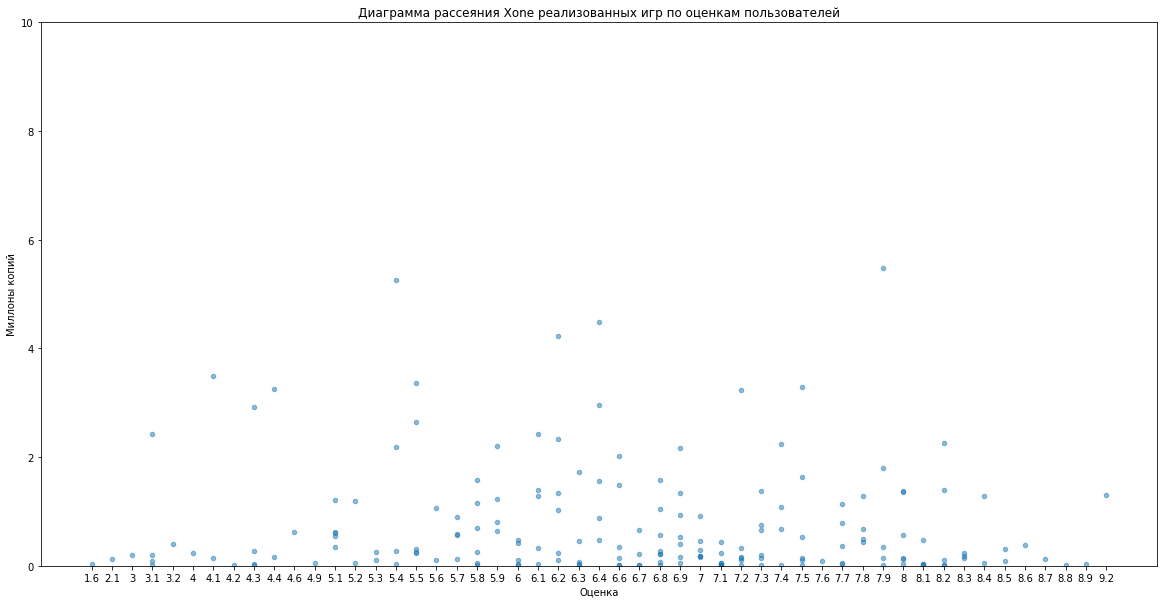

-0.06892505328279418

In [23]:
xone = df2.dropna(subset = ['user_score'])
xone = xone.query('platform == "xone" & user_score != "nan"').sort_values(by = 'user_score')
xone.plot.scatter (x = 'user_score', y = 'sum_sales', figsize = (20, 10), alpha = 0.5);
plt.ylim(0, 10)
plt.title('Диаграмма рассеяния Xone реализованных игр по оценкам пользователей')
plt.xlabel('Оценка')
plt.ylabel('Миллоны копий')
plt.show()
xone['user_score'] = xone['user_score'].astype(float)
xone['user_score'].corr(xone['sum_sales'])

Аналогичная ситуация с оценками пользователей по продажам игр на xone. Какая-либо связь отсутствует.

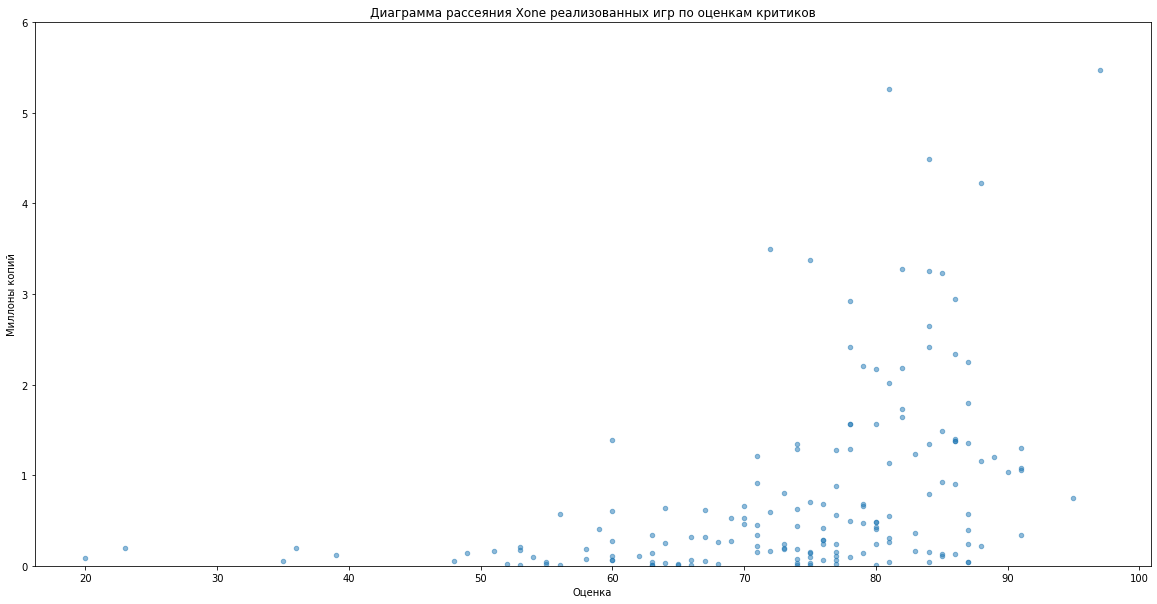

0.41042203561296375

In [24]:
xone.plot.scatter (x = 'critic_score', y = 'sum_sales', figsize = (20, 10), alpha = 0.5);
plt.ylim(0, 6)
plt.title('Диаграмма рассеяния Xone реализованных игр по оценкам критиков')
plt.xlabel('Оценка')
plt.ylabel('Миллоны копий')
plt.show()
xone['critic_score'] = xone['critic_score'].astype(float)
xone['critic_score'].corr(xone['sum_sales'])

Аналогичная ситуация с оценками пользователей по продажам игр на xone. Слабая связь присутствует.

In [25]:
df2['critic_score'] = df2['critic_score'].astype(float)
df2['user_score'] = df2['user_score'].astype(float)
platform = df2['platform'].unique()
corr_critic = [df2[df2['platform'] == i]['critic_score'].corr(df2[df2['platform'] == i]['sum_sales']) for i in platform]
corr_user = [df2[df2['platform'] == i]['user_score'].corr(df2[df2['platform'] == i]['sum_sales']) for i in platform]

rev = {'Платформа': platform, 'Корреляция игр по оценкам критиков': corr_critic,
      'Корреляция игр по оценкам пользователей': corr_user}
rev_df = pd.DataFrame(rev)
rev_df.sort_values(by = 'Корреляция игр по оценкам критиков', ascending = False)

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Платформа,Корреляция игр по оценкам критиков,Корреляция игр по оценкам пользователей
5,xone,0.416998,-0.068925
2,ps4,0.406568,-0.031957
1,x360,0.360573,0.006164
6,wiiu,0.348380,0.400219
0,ps3,0.334152,-0.006206
3,3ds,0.320803,0.197583
8,pc,0.237243,-0.121867
9,psv,0.094488,-0.004339
7,wii,-0.424341,0.296197
4,ds,NaN,0.882709


Заметим, что те платформы, которые нас интересуют в дальнейшем анализе, подтверждают гипотезу о том, что пользовательские оценки не так сильно помогают играм продаваться лучше, чем оценки критиков. Но есть 2 платформы: wiiu и 3ds. Оценки пользователей и критиков для данных платформ одинаково влияют на динамику продаж игр. Предположу, что данные платформы популярны лишь для определенного региона (Японии), где оценки выставляются иным образом. 

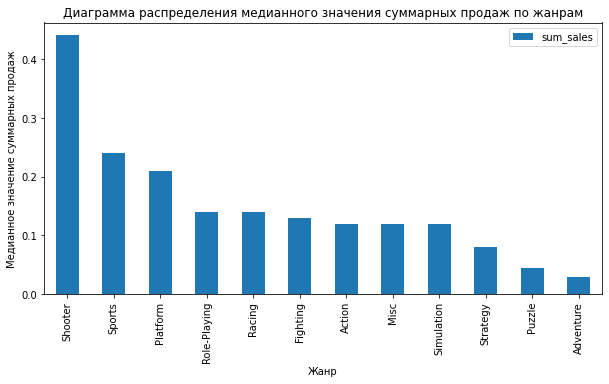

In [26]:
df2.pivot_table(index='genre', aggfunc={'sum_sales': 'median'}).sort_values(by='sum_sales', ascending=False).plot(y='sum_sales', kind='bar', figsize=(10, 5))
plt.title('Диаграмма распределения медианного значения суммарных продаж по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Медианное значение суммарных продаж');

Наиболее популярным жанром является Shooter и Sports. Эти категории уверенно лидируют. Наименее популярными жанрами являются пазлы и адвенты.

### Портреты пользователей


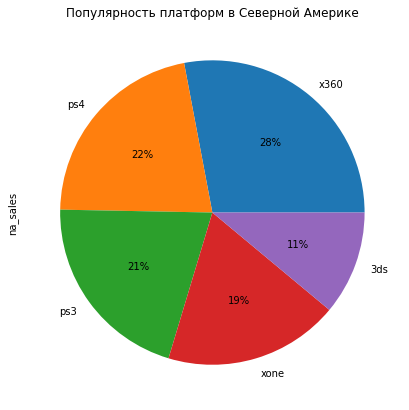

In [27]:
na_df = df2.groupby('platform')['na_sales'].sum().sort_values(ascending = False).nlargest(5, keep = 'first')
na_df.plot(kind='pie',y="na_sales", autopct='%1.0f%%',
           title = "Популярность платформ в Северной Америке", figsize=(7, 7));

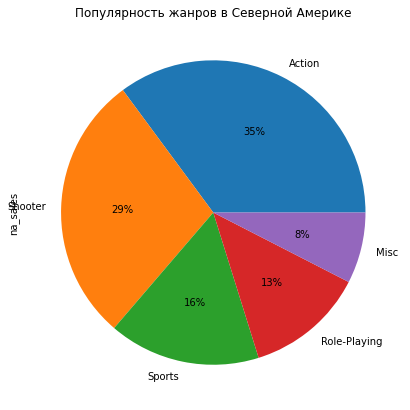

In [28]:
na_df = df2.groupby('genre')['na_sales'].sum().sort_values(ascending = False).nlargest(5, keep = 'first')
na_df.plot(kind='pie',y="na_sales", autopct='%1.0f%%', 
           title = "Популярность жанров в Северной Америке", figsize=(7, 7));

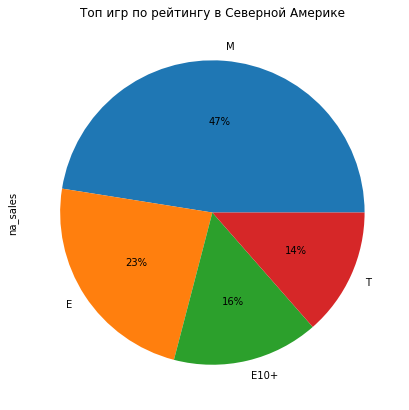

In [29]:
na_df = df2.groupby('rating')['na_sales'].sum().sort_values(ascending = False)
na_df.plot(kind='pie',y="na_sales", autopct='%1.00f%%', 
           title = "Топ игр по рейтингу в Северной Америке", figsize=(7, 7));

Таким образом, типичный потребитель Северной Америки использует платформу x360, приобретая игры жанра экшн, возрастная категория которых М (17+ лет). На самом деле, данный портрет может быть искажен совсем недавним выходом новых платформ, которые численно еще на стали такими популярными, но, визуально, стремительный рост продаж игр на платформы нового поколения дает нам 99% уверенность, что альтернативным портретом является пользователь на платформе ps4, который играет в экшн игры и шутеры, рейтинг которых 17+ лет. Огромное количество значений 'tbd' в данных рэйтинга, по моему мнению, связано с появлением новых платформ и, как следствие, новых игр, которые еще не получили возрастного рейтинга.

#### EU

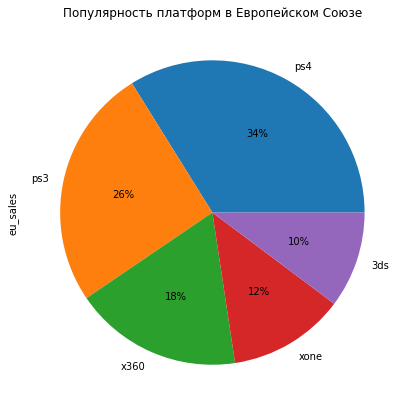

In [30]:
eu_df = df2.groupby('platform')['eu_sales'].sum().sort_values(ascending = False).nlargest(5, keep = 'first')
eu_df.plot(kind='pie',y="eu_sales", autopct='%1.0f%%',
           title = "Популярность платформ в Европейском Союзе", figsize=(7, 7));

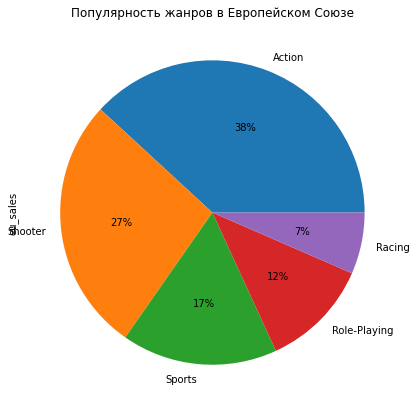

In [31]:
eu_df = df2.groupby('genre')['eu_sales'].sum().sort_values(ascending = False).nlargest(5, keep = 'first')
eu_df.plot(kind='pie',y="eu_sales", autopct='%1.0f%%', 
           title = "Популярность жанров в Европейском Союзе", figsize=(7, 7));

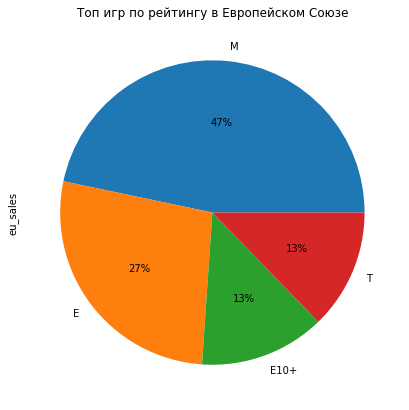

In [32]:
eu_df = df2.groupby('rating')['eu_sales'].sum().sort_values(ascending = False)
eu_df.plot(kind='pie',y="eu_sales", autopct='%1.00f%%', 
           title = "Топ игр по рейтингу в Европейском Союзе", figsize=(7, 7));

Типичный потребитель Европейского Союза использует платформы компании Sony (ps3, ps4), приобретая игры жанра экшн и шутер, возрастная категория которых М (17+ лет).

#### JP

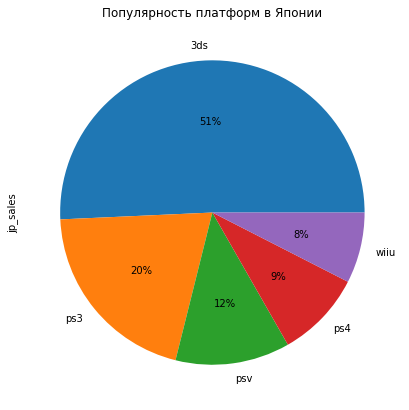

In [33]:
jp_df = df2.groupby('platform')['jp_sales'].sum().sort_values(ascending = False).nlargest(5, keep = 'first')
jp_df.plot(kind='pie',y="jp_sales", autopct='%1.0f%%',
           title = "Популярность платформ в Японии", figsize=(7, 7));

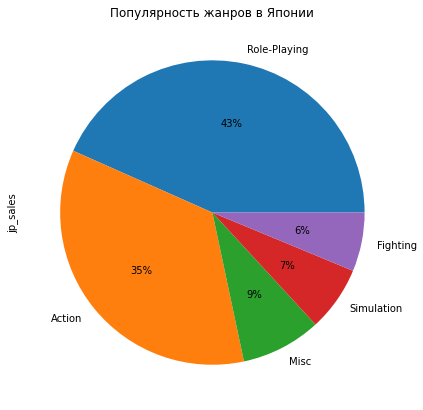

In [34]:
jp_df = df2.groupby('genre')['jp_sales'].sum().sort_values(ascending = False).nlargest(5, keep = 'first')
jp_df.plot(kind='pie',y="jp_sales", autopct='%1.0f%%', 
           title = "Популярность жанров в Японии", figsize=(7, 7));

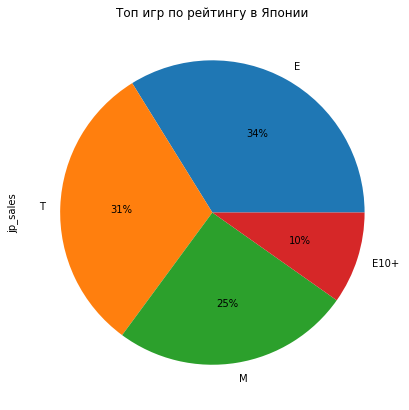

In [35]:
jp_df = df2.groupby('rating')['jp_sales'].sum().sort_values(ascending = False)
jp_df.plot(kind='pie',y="jp_sales", autopct='%1.00f%%', 
           title = "Топ игр по рейтингу в Японии", figsize=(7, 7));

Типичный потребитель Японии использует платформу 3ds, приобретая игры жанра role-play и action, возрастная категория которых E (для всех возрастов). Возрастная категория, как уже сказано было ранее, имеет очень много пропусков, что может искажать портрет.

### Проверка гипотез


In [36]:

xone = df2.dropna(subset = ['user_score'])
xone = xone.query('platform == "xone" & user_score != "nan"').sort_values(by = 'user_score')
xone.loc[:,'user_score'] = xone.loc[:,'user_score'].astype(float)

pc = df2.dropna(subset = ['user_score'])
pc = pc.query('platform == "pc" & user_score != "nan"').sort_values(by = 'user_score')
pc.loc[:,'user_score'] = pc.loc[:,'user_score'].astype(float)

if np.var(xone.loc[:,'user_score']) != np.var(pc.loc[:,'user_score']):
    print('Дисперсии выборок не равны')
else:
    print('Дисперсии выборок равны')

Дисперсии выборок не равны


Дисперсии выборок не равны, поэтому equal_var==False

H0: Cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.

H1: cредние пользовательские рейтинги платформ Xbox One и PC различаются.

In [37]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    xone['user_score'], 
    pc['user_score'],
    equal_var = False)

print('p-значение: {:.5f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, рейтинги платформ Xbox One и PC разные")
else:
    print("Не получилось отвергнуть нулевую гипотезу, рейтинги платформ Xbox One и PC одинаковые")

p-значение: 0.54895
Не получилось отвергнуть нулевую гипотезу, рейтинги платформ Xbox One и PC одинаковые


Предполагаю, что рейтинги данных 2-ух платформ совпадают, так как большинство PC являются игровой платформой благодаря Microsoft с ее Windows. Microsoft так же является разработчиком Xbox one. Это значит, что данные 2 платформы родны. Следственно, игры, которые выпускались и выпускаются на данные платформы, совпадают. Соответственно, совпадают и рейтинги этих игр.

In [38]:
action = df2.dropna(subset = ['user_score'])
action = action.query('genre == "Action" & user_score != "nan"').sort_values(by = 'user_score')
action.loc[:,'user_score'] = action.loc[:,'user_score'].astype(float)

sports = df2.dropna(subset = ['user_score'])
sports = sports.query('genre == "Sports" & user_score != "nan"').sort_values(by = 'user_score')
sports.loc[:,'user_score'] = sports.loc[:,'user_score'].astype(float)


if np.var(action.loc[:,'user_score']) != np.var(sports.loc[:,'user_score']):
    print('Дисперсии выборок не равны')
else:
    print('Дисперсии выборок равны')
                   

Дисперсии выборок не равны


Дисперсии выборок не равны, поэтому equal_var==False

H0: Cредние пользовательские рейтинги жанров экшн и спорт совпадают.

H1: Cредние пользовательские рейтинги жанров экшн и спорт различаются.


In [39]:
alpha = .05 

results = st.ttest_ind(
    action['user_score'], 
    sports['user_score'],
    equal_var = False)

print('p-значение: {:.20f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00000000000000000006
Отвергаем нулевую гипотезу


Нулевая гипотеза может отвергнута. Средние пользовательские рейтинги жанров Action и Sports различаются.

### Общий Вывод

По итогам проделанной работы, было выполнено:

1. Было определено, что для анализа и прогноза, необходимо изучать данные за последние 5 лет (2012-2016 г).
2. Были найдены наиболее актуальные платформы, которые лидируют по продажам.
3. Был построен ящик с усами по глобальным продажам игр в разбивке платформ.
4. Было проанализировано влияние оценок критиков, пользователей на итоговые суммарные продажи. 
5. Был произведен анализ жанров в разрезе их прибыльности.
6. Был составлен портрет пользователя для каждого региона в разрезе платформ, жанров и рейтинга.
7. Были проверены гипотезы: 

7.1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

7.2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Кампания на 2017 год должна ориентироваться на платформы нового поколения - Xbox One и PS4. Несмотря на то, что в топе на текущий год находятся ps3, xbox 360 и 3ds, динамика платформ нового поколения и старого поколения явно демонстрирует это.

Жанры, в сторону которых нужно ориентироваться - Sports и Shooter. Японцы любят Role-Play, но доля Японии в общих данных не такая значительная, чтобы смотреть в сторону ролевиков.

Рейтинг игр, исходя из анализа, должен быть 17+.

Оценки пользователей формируются уже после покупки и прохождения игры. Это логично, ведь рядовой пользователь не может объективно судить игру до ее выхода. Как раз таки критики получают доступ к играм заранее и до начала продаж могут выставить оценки. Если кампания будет ориентироваться на Японию, то данное правило теряет свою актуальность.

При изучении пользовательских оценок Xbox One и PC, мы выяснили, что их разделение, в данном ключе, не совсем справедливо, ведь игры для данных платформ совпадают и, видимо, экспипренс игроков совпадает.